<header>
   <p  style='font-size:36px;font-family:Arial; color:#F0F0F0; background-color: #00233c; padding-left: 20pt; padding-top: 20pt;padding-bottom: 10pt; padding-right: 20pt;'>
       Total Knee Replacement: Attribution Analysis
  <br>
       <img id="teradata-logo" src="https://storage.googleapis.com/clearscape_analytics_demo_data/DEMO_Logo/teradata.svg" alt="Teradata" style="width: 125px; height: auto; margin-top: 20pt;">
    </p>
</header>
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Introduction</b></p>


<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Attribution</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Attribution is the process of assigning a value to specific activities that sequentially result in an event. Which event contributes how much to the final outcome is what attribution determines. The Attribution function is used in web page analysis, where it lets companies assign weights to pages before certain events, such as buying a product. The goal of attribution is to determine which channels and messages had the greatest impact on the decision to convert or take the desired next step. 
There are several popular attribution models used by marketers today, such as multi-touch attribution, lift studies, time decay, and more.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>In this script, we will apply the `ATTRIBUTION` function on a pathing dataset using all four prepared attribution models that define the weight of events in a sequence. Below are the types of Attribution models we will be using.</p>



 <table style = 'font-size:16px;font-family:Arial;color:#00233C'>
  <tr>
    <th>Distribution Model</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>'LAST_CLICK'</td>
    <td>Conversion event is attributed entirely to most recent attributable event.</td>  
  </tr>
  <tr>
    <td>'FIRST_CLICK'</td>
    <td>Conversion event is attributed entirely to first attributable event.</td>  
  </tr>
  <tr>
    <td>'UNIFORM'</td>
    <td>Conversion event is attributed uniformly to preceding attributable events.</td>  
  </tr>
  <tr>
    <td>'EXPONENTIAL'</td>
    <td>Conversion event is attributed exponentially to preceding attributable events (the more recent the event, the higher the attribution).</td>  
  </tr>
</table>


<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>1. Connect to Vantage </b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>You will be prompted to provide the password. Enter your password, press Enter, then use down arrow to go to next cell.</p>

In [1]:
%connect local, hidewarnings=true

Password: ········


Success: 'local' connection established and activated for user 'demo_user', with default database 'demo_user'


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Setup for execution of notebook. Begin running steps with Shift + Enter keys.</p>


In [2]:
Set query_band='DEMO=Knee_Replacement_Attribution_SQL.ipynb;' update for session;

Success: 1 rows affected

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>2. Getting Data for This Demo</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We have provided data for this demo on cloud storage.  You have the option of either running the demo using foreign tables to access the data without using any storage on your environment or downloading the data to local storage which may yield somewhat faster execution, but there could be considerations of available storage.  There are two statements in the following cell, and one is commented out.  You may switch which mode you choose by changing the comment string.</p>


In [3]:
call get_data('DEMO_KneeReplacement_cloud'); ---takes about 10 seconds
---call get_data('DEMO_KneeReplacement_local'); ---takes about 30 seconds

Success: 0 rows affected

Success: 0 rows affected

,Message
1,That ran for 0:00:13.93 with 4 statements and 0 errors.


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Optional step – if you want to see status of databases/tables created and space used.</p>


In [4]:
call space_report();  -- optional, takes about 10 seconds

Success: 0 rows affected

Success: 0 rows affected

,Space_Report
1,"You have: #databases=3 #tables=53 #views=4 You have used 15.0 MB of 27,890.4 MB available - 0.1% ... Space Usage OK"
2,
3,Database Name #tables #views Avail MB Used MB
4,"demo_user 52 2 27,880.3 MB 14.8 MB"
5,DEMO_GraphAnalysis 0 1 0.0 MB 0.0 MB
6,DEMO_GraphAnalysis_db 1 0 10.1 MB 0.2 MB
7,DEMO_KneeReplacement 0 1 0.0 MB 0.0 MB


<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>3. Create Some Attribution Models</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>In order to apply the `ATTRIBUTION` function on a pathing dataset, first we need to specify an attribution model. An attribution model defines how we are going to weight the activities that precede an event. </p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>There are five model types that we can use: 
<li style = 'font-size:16px;font-family:Arial;color:#00233C'>*first event model*: the first event gets 100% of the weight </li>
<li style = 'font-size:16px;font-family:Arial;color:#00233C'>*last event model*: the last event gets 100% of the weight </li>
<li style = 'font-size:16px;font-family:Arial;color:#00233C'>*uniform event model*: all events are given equal weight  </li>
<li style = 'font-size:16px;font-family:Arial;color:#00233C'>*exponential model*: each subsequent event in a sequence is given a higher weight than the preceding activity</li>
<li style = 'font-size:16px;font-family:Arial;color:#00233C'>*weighted model*: attributed to preceding attributable events with weights specified by PARAMETERS.SEGMENT_SECONDS (specified by 'rows:K&seconds:K' in WindowSize syntax element)</li></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The total weight of all activities should equal to 1 (100%). Below are some Create table and Insert statements which will create model tables which will be used in the Attribution function.</p>

<p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b> Model 1: First Click Model</b></p>

In [5]:
CREATE TABLE attribution_model_first (
    id INT, 
    model VARCHAR(100) 
); 

Success: 0 rows affected

In [6]:
INSERT INTO attribution_model_first VALUES (0,'EVENT_REGULAR'); 
INSERT INTO attribution_model_first VALUES (1, 'ALL:1.0:FIRST_CLICK:NA'); 

Success: 1 rows affected

Success: 1 rows affected

<p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b> Model 2: Last Click Model </b></p>



In [7]:
CREATE TABLE attribution_model_last (
    id INT,
    model VARCHAR(100) 
); 

Success: 0 rows affected

In [8]:
INSERT INTO attribution_model_last VALUES (0, 'EVENT_REGULAR'); 
INSERT INTO attribution_model_last VALUES (1, 'ALL:1.0:LAST_CLICK:NA'); 

Success: 1 rows affected

Success: 1 rows affected

<p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b> Model 3: Uniform Event Model</b></p>


In [9]:
CREATE TABLE attribution_model_uniform (
    id INT, 
    model VARCHAR(100) 
); 

Success: 0 rows affected

In [10]:
INSERT INTO attribution_model_uniform VALUES (0, 'EVENT_REGULAR'); 
INSERT INTO attribution_model_uniform VALUES (1, 'ALL:1.0:UNIFORM:NA'); 

Success: 1 rows affected

Success: 1 rows affected

<p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b> Model 4: Exponential Event Model</b></p>


In [11]:
CREATE TABLE attribution_model_exponential (
    id INT, 
    model VARCHAR(100) 
); 

Success: 0 rows affected

In [12]:
INSERT INTO attribution_model_exponential VALUES (0, 'EVENT_REGULAR'); 
INSERT INTO attribution_model_exponential VALUES (1, 'ALL:1.0:EXPONENTIAL:0.5,ROW'); 

Success: 1 rows affected

Success: 1 rows affected

<p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b> Create Event of Interest (EOI) Table</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Since here we are trying to analyze the events that led to Total Knee Replacement our final Event of interest will be the same. </p>

In [13]:
CREATE TABLE ATTRIBUTION_EOI( 
    event_of_interest VARCHAR(100)
);

Success: 0 rows affected

In [14]:
INSERT INTO ATTRIBUTION_EOI VALUES ('TOTAL KNEE REPLACEMENT');  

Success: 1 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Before moving ahead let's check the data in these model tables to verify that we have correct data. </p>

In [15]:
SELECT * FROM attribution_model_first; 

,id,model
1,0,EVENT_REGULAR
2,1,ALL:1.0:FIRST_CLICK:NA


In [16]:
SELECT * FROM attribution_model_last; 

,id,model
1,0,EVENT_REGULAR
2,1,ALL:1.0:LAST_CLICK:NA


In [17]:
SELECT * FROM attribution_model_uniform; 

,id,model
1,0,EVENT_REGULAR
2,1,ALL:1.0:UNIFORM:NA


In [18]:
SELECT * FROM attribution_model_exponential; 

,id,model
1,0,EVENT_REGULAR
2,1,"ALL:1.0:EXPONENTIAL:0.5,ROW"


In [19]:
SELECT * FROM ATTRIBUTION_EOI; 

,event_of_interest
1,TOTAL KNEE REPLACEMENT


<p style = 'font-size:14px;font-family:Arial'><b> *Caution*: If more than the 2 rows are inserted for any attribution model table, it will err. Drop the table and reinsert.</b></p>

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>4. Sessionize Function </b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The Sessionize function maps each click in a session to a unique session identifier. A session is a sequence of clicks by one user that are separated by at most n seconds. The function is useful for both sessionization and detecting web crawler ("bot") activity. A typical use is to understand user browsing behavior on a web site.</p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>However, we've also found it useful to define a sequence of events along a longitudinal record of a member's patient journey. In this case, we will define a session as one day.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>one day = 60 seconds x 60 minutes x 24 hours = 86,400 seconds</p>


In [20]:
CREATE MULTISET TABLE KneeSessions AS (
    SELECT 
        *
    FROM SESSIONIZE (
        ON(
            SELECT memberid, 
                diagcode, 
                proccode, 
                TRANSLATE(shortdesc USING UNICODE_TO_LATIN) as shortdesc,
                amount, 
                tstamp, 
                lastname, 
                firstname, 
                state, 
                email
            FROM DEMO_KneeReplacement.knee_replacement
        )
        PARTITION BY memberid
        ORDER BY tstamp
        USING
            TIMECOLUMN('tstamp')
            TIMEOUT(86400)
            EMITNULL('true')
    ) 
) WITH DATA;

Success: 0 rows affected

<p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b>View Data</b></p>

In [21]:
SELECT TOP 5 * FROM KneeSessions; 

,memberid,diagcode,proccode,shortdesc,amount,tstamp,lastname,firstname,state,email,SESSIONID
1,350006,92811:CRUSHING INJURY KNEE,9339,PHYSICAL THERAPY NEC,250.95,2017-04-14 18:54:10.000000,Taglauer,Lorene,RI,lorene@taglauer.com,2
2,350006,92811:CRUSHING INJURY KNEE,9339,PHYSICAL THERAPY NEC,250.95,2017-04-28 23:50:11.000000,Taglauer,Lorene,RI,lorene@taglauer.com,4
3,350006,92811:CRUSHING INJURY KNEE,8016,OTH ARTHROTOMY-KNEE,300.95,2017-04-18 16:48:16.000000,Taglauer,Lorene,RI,lorene@taglauer.com,3
4,350006,92811:CRUSHING INJURY KNEE,9339,PHYSICAL THERAPY NEC,250.95,2017-04-11 05:51:07.000000,Taglauer,Lorene,RI,lorene@taglauer.com,1
5,350006,92811:CRUSHING INJURY KNEE,9305,RANGE OF MOTION TESTING,150.95,2017-03-31 09:47:54.000000,Taglauer,Lorene,RI,lorene@taglauer.com,0


<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>5. Attribution.</b</p>
<p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b> Run the Attribution Function Using A Uniform Attribution Distribution.</b></p>

In [22]:
SELECT TOP 5
    F.memberid, F.SESSIONID, F.tstamp, F.shortdesc as event,
    F.ATTRIBUTION AS attribution_score
FROM ATTRIBUTION (
         ON KneeSessions AS INPUT
         PARTITION BY memberid
         ORDER BY tstamp
         ON ATTRIBUTION_EOI AS CONVERSION DIMENSION
         ON ATTRIBUTION_MODEL_UNIFORM AS MODEL1 DIMENSION
         USING
             EventColumn ('shortdesc')
             TIMESTAMPCOLUMN ('tstamp')
             WINDOWSIZE('seconds:31536000') -- 5 years
     ) F
     order by 1,2,5;

,memberid,SESSIONID,tstamp,event,attribution_score
1,350001,0,2017-01-18 03:39:12.000000,RANGE OF MOTION TESTING,0.2
2,350001,1,2017-01-28 03:36:12.000000,PHYSICAL THERAPY NEC,0.2
3,350001,2,2017-01-30 14:14:34.000000,PHYSICAL THERAPY NEC,0.2
4,350001,3,2017-02-01 16:43:51.000000,OTH ARTHROTOMY-KNEE,0.2
5,350001,4,2017-02-06 14:11:12.000000,SKEL XRAY-THIGH/KNEE/LEG,0.2


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The output of the Attribution function using Uniform Attribution assigns equal weight to each event in a particular path apart from the Event of Interest which is 'TOTAL KNEE REPLACEMENT' in this case.</p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'> <b>Create Attribution Model Outputs Table</b></p>


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Write Outputs of all Attribution Model Types for Comparison

In [23]:
CREATE MULTISET TABLE ATTRIBUTION_MODEL_OUTPUT AS (
    SELECT F.memberid as MEMBERID, F.SESSIONID as EVENTORDER, 
        F.tstamp as datestamp, F.shortdesc as EVENT,
        F.ATTRIBUTION AS FIRST_CLICK_ATTRIBUTION,
        L.ATTRIBUTION AS LAST_CLICK_ATTRIBUTION,
        U.ATTRIBUTION AS UNIFORM_ATTRIBUTION,
        E.ATTRIBUTION AS EXPONENTIAL_ATTRIBUTION
    FROM ATTRIBUTION (
         ON KneeSessions AS INPUT
         PARTITION BY memberid
         ORDER BY tstamp
         ON ATTRIBUTION_EOI AS CONVERSION DIMENSION
         ON ATTRIBUTION_MODEL_FIRST AS MODEL1 DIMENSION
         USING
             EventColumn ('shortdesc')
             TIMESTAMPCOLUMN ('tstamp')
             WINDOWSIZE('seconds:31536000') -- 5 years
     ) F
    ,ATTRIBUTION (
         ON KneeSessions AS INPUT
         PARTITION BY memberid
         ORDER BY tstamp
         ON ATTRIBUTION_EOI AS CONVERSION DIMENSION
         ON ATTRIBUTION_MODEL_LAST AS MODEL1 DIMENSION
         USING
             EventColumn ('shortdesc')
             TIMESTAMPCOLUMN ('tstamp')
             WINDOWSIZE('seconds:31536000') -- 5 years
     ) L
    ,ATTRIBUTION (
         ON KneeSessions AS INPUT
         PARTITION BY memberid
         ORDER BY tstamp
         ON ATTRIBUTION_EOI AS CONVERSION DIMENSION
         ON ATTRIBUTION_MODEL_UNIFORM AS MODEL1 DIMENSION
         USING
             EventColumn ('shortdesc')
             TIMESTAMPCOLUMN ('tstamp')
             WINDOWSIZE('seconds:31536000') -- 5 years
     ) U
    ,ATTRIBUTION (
         ON KneeSessions AS INPUT
         PARTITION BY memberid
         ORDER BY tstamp
         ON ATTRIBUTION_EOI AS CONVERSION DIMENSION
         ON ATTRIBUTION_MODEL_EXPONENTIAL AS MODEL1 DIMENSION
         USING
             EventColumn ('shortdesc')
             TIMESTAMPCOLUMN ('tstamp')
             WINDOWSIZE('seconds:31536000') -- 5 years
     ) E
WHERE F.memberid = L.memberid
AND   F.memberid = U.memberid
AND   F.memberid = E.memberid
AND   F.tstamp = L.tstamp
AND   F.tstamp = U.tstamp
AND   F.tstamp = E.tstamp
AND   F.shortdesc = L.shortdesc
AND   F.shortdesc = U.shortdesc
AND   F.shortdesc = E.shortdesc
)
WITH DATA;

Success: 0 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>View Attribution Outputs for Single Member</b></p>

In [24]:
SELECT * FROM ATTRIBUTION_MODEL_OUTPUT WHERE MEMBERID=350031 ORDER BY 2 ASC ;

,MEMBERID,EVENTORDER,datestamp,EVENT,FIRST_CLICK_ATTRIBUTION,LAST_CLICK_ATTRIBUTION,UNIFORM_ATTRIBUTION,EXPONENTIAL_ATTRIBUTION
1,350031,0,2017-01-07 18:19:57.000000,OTH ARTHROTOMY-KNEE,1,0,0.09090909090909091,0.0004885197850512946
2,350031,1,2017-01-10 03:41:17.000000,OTH ARTHROTOMY-KNEE,0,0,0.09090909090909091,0.0009770395701025891
3,350031,2,2017-01-11 09:06:05.000000,KNEE SYNOVECTOMY,0,0,0.09090909090909091,0.0019540791402051783
4,350031,3,2017-01-17 05:32:48.000000,KNEE JOINT BIOPSY,0,0,0.09090909090909091,0.0039081582804103565
5,350031,4,2017-01-18 13:55:26.000000,SKEL XRAY-THIGH/KNEE/LEG,0,0,0.09090909090909091,0.007816316560820713
6,350031,5,2017-01-24 17:24:52.000000,OTH ARTHROTOMY-KNEE,0,0,0.09090909090909091,0.015632633121641426
7,350031,6,2017-01-26 05:20:25.000000,PHYSICAL THERAPY NEC,0,0,0.09090909090909091,0.03126526624328285
8,350031,7,2017-02-03 08:22:57.000000,SKEL XRAY-THIGH/KNEE/LEG,0,0,0.09090909090909091,0.0625305324865657
9,350031,8,2017-02-14 08:19:45.000000,SKEL XRAY-THIGH/KNEE/LEG,0,0,0.09090909090909091,0.1250610649731314
10,350031,9,2017-02-16 17:43:32.000000,OTH ARTHROTOMY-KNEE,0,0,0.09090909090909091,0.2501221299462628


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The above output of the Attribution Models is as below: 
<li style = 'font-size:16px;font-family:Arial;color:#00233C'>*first event model*: the first event gets 100% of the weight :-  In the above output for the given member 'OTH ARTHROTOMY-KNEE' is the first click attribution i.e. the first event.</li> 
<li style = 'font-size:16px;font-family:Arial;color:#00233C'>*last event model*: the last event gets 100% of the weight :- As seen in the output 'KNEE JOINT BIOPSY' is the last click attribution i.e. the last event before the event of Interest.</li>
<li style = 'font-size:16px;font-family:Arial;color:#00233C'> *uniform event model*: all events are given equal weight :- As in the Uniform distribution column each event for that particular member is given equal weight i.e. 1/(Numberofevents-1) will give the attribution for each event.</li>
<li style = 'font-size:16px;font-family:Arial;color:#00233C'>*exponential model*: each subsequent event in a sequence is given a higher weight than the preceding activity :- the exponential attribution is lowest for the first event and highest for the last event.</li>
</p>


<p style = 'font-size:18px;font-family:Arial;color:#00233C'>Sum up the attribution values for each event/model combination</p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Totals for each event/model combination should equal 1.0 (100%) for each member.</p>

In [25]:
SELECT TOP 5 MEMBERID
       ,SUM(FIRST_CLICK_ATTRIBUTION) AS FIRST_CLICK_TOTAL
       ,SUM(LAST_CLICK_ATTRIBUTION)  AS LAST_CLICK_TOTAL
       ,SUM(UNIFORM_ATTRIBUTION)     AS UNIFORM_TOTAL
       ,SUM(EXPONENTIAL_ATTRIBUTION) AS EXPONENTIAL_TOTAL
FROM ATTRIBUTION_MODEL_OUTPUT
GROUP BY MEMBERID; 

,MEMBERID,FIRST_CLICK_TOTAL,LAST_CLICK_TOTAL,UNIFORM_TOTAL,EXPONENTIAL_TOTAL
1,372886,1,1,1,1
2,362163,1,1,1,0.9999999999999999
3,381005,1,1,1,0.9999999999999999
4,378425,1,1,1,1
5,352766,1,1,1,1


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>As seen in the above output the totals for each event/model combination is equal to/nearing 1.0 (100%) for each member.</p>
<p style = 'font-size:18px;font-family:Arial;color:#00233C'>Sum attribution values for each event</p>

In [26]:
SELECT EVENT
       ,SUM(FIRST_CLICK_ATTRIBUTION) AS FIRST_CLICK_ATTRIBUTION
       ,SUM(LAST_CLICK_ATTRIBUTION)  AS LAST_CLICK_ATTRIBUTION
       ,SUM(UNIFORM_ATTRIBUTION)     AS UNIFORM_ATTRIBUTION
       ,SUM(EXPONENTIAL_ATTRIBUTION) AS EXPONENTIAL_ATTRIBUTION
FROM ATTRIBUTION_MODEL_OUTPUT
GROUP BY EVENT
ORDER BY 3 DESC; 

,EVENT,FIRST_CLICK_ATTRIBUTION,LAST_CLICK_ATTRIBUTION,UNIFORM_ATTRIBUTION,EXPONENTIAL_ATTRIBUTION
1,KNEE JOINT BIOPSY,134,6853,1518.120133091847,3667.8067681261573
2,KNEE ARTHROSCOPY,126,5261,1828.3676070188392,3619.298329857854
3,OTHER DIAGNOSTIC PHYSICAL THERAPY PROCEDURE,0,1938,363.6629836666626,997.4909149086209
4,OTH ARTHROTOMY-KNEE,133,567,3628.1780402992326,3627.9258138229916
5,PHYSICAL THERAPY NEC,114,277,4546.251630984565,2329.176979403036
6,SKEL XRAY-THIGH/KNEE/LEG,3563,249,910.8024095958976,378.1904631362621
7,TRIAD KNEE REPAIR,121,245,255.5054383911599,268.47105163169573
8,EXCIS KNEE SEMILUN CARTL,145,237,268.478592563269,268.11746919169207
9,KNEE SYNOVECTOMY,108,231,258.4355625755411,267.4573001704249
10,KNEE STRUCTURE DIVISION,120,215,262.5158766414201,254.95417873057914


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The above output shows the values of each type of Attribution for EACH event that we have in the different PATHS and the totals for each event/model combination.</p>
<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>6. Visualization</b></p>
    <p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b>Visualize Using Data from the Last Query</p>

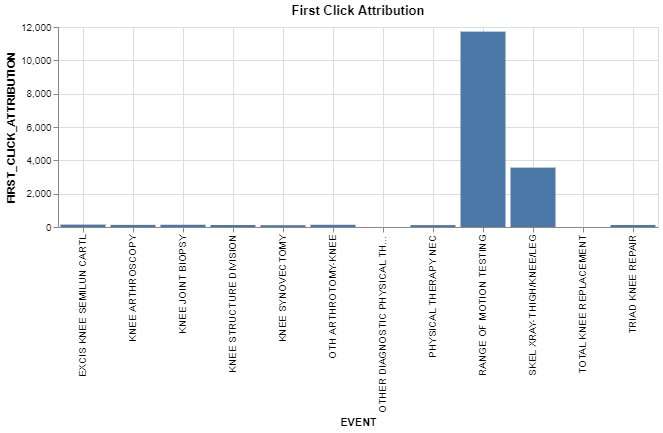

In [27]:
%chart EVENT, FIRST_CLICK_ATTRIBUTION  , title="First Click Attribution", width = 600 

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The above output shows the total of each type of event for FIRST CLICK ATTRIBUTION. It means that the event <b>RANGE OF MOTION TESTING</b> was the first event in maximum number of cases followed by SKEL XRAY - THIGH/KNEE/LEG.</p>

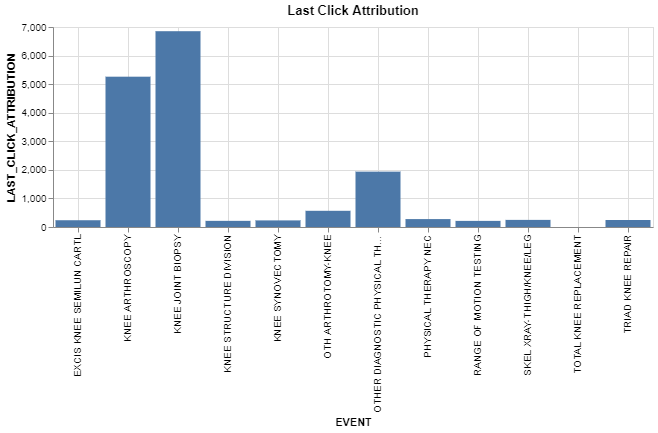

In [28]:
%chart EVENT, LAST_CLICK_ATTRIBUTION, title="Last Click Attribution", width = 600

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The above output shows the total of each type of event for LAST CLICK ATTRIBUTION i.e. the last event before TOTAL KNEE REPLACEMENT. The event <b>KNEE JOINT BIOPSY </b> was the last event in maximum number of cases followed by KNEE ARTHROSCOPY.</p>

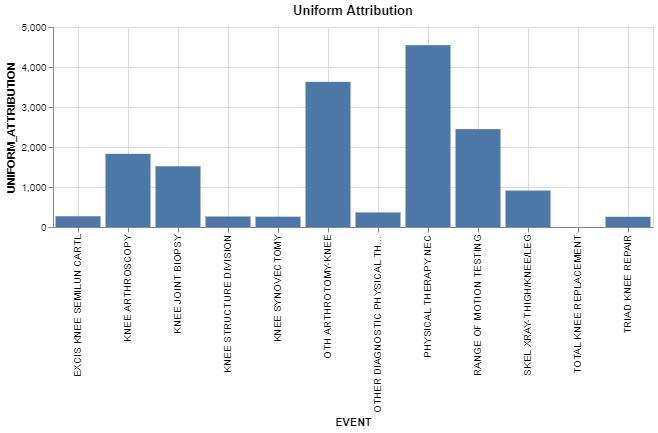

In [29]:
%chart EVENT, UNIFORM_ATTRIBUTION, title="Uniform Attribution", width = 600

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The above output shows the total of each type of event for UNIFORM ATTRIBUTION i.e. the occurrence of each event when the weights are uniformly distributed. The event <b>PHYSICAL THERAPY NEC</b> shows the maximum number of occurrences followed by OTH ARTHROTOMY-KNEE.</p>

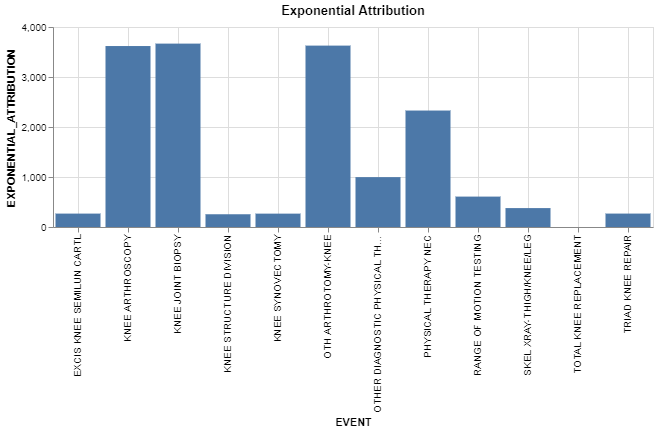

In [30]:
%chart EVENT, EXPONENTIAL_ATTRIBUTION, title="Exponential Attribution" , width = 600

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The above output shows the total of each type of event for EXPONENTIAL ATTRIBUTION i.e. the first event has minimum weight and the last event has maximum weight. The above chart shows that the events KNEE ARTHROSCOPY, KNEE JOINT BIOPSY and OTH ARTHROTOMY-KNEE show almost similar number of cases where these events have the highest weights.</p>

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>7. Cleanup</b></p>
<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Work Tables</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Clean up the work tables to prevent error next time.</p>

In [31]:
DROP TABLE attribution_model_first;

Success: 15 rows affected

In [32]:
DROP TABLE attribution_model_last; 

Success: 15 rows affected

In [33]:
DROP TABLE attribution_model_uniform;

Success: 15 rows affected

In [34]:
DROP TABLE attribution_model_exponential; 

Success: 15 rows affected

In [35]:
DROP TABLE ATTRIBUTION_EOI; 

Success: 14 rows affected

In [36]:
DROP TABLE KneeSessions;

Success: 24 rows affected

In [37]:
DROP TABLE ATTRIBUTION_MODEL_OUTPUT;  

Success: 21 rows affected

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Databases and Tables</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The following code will clean up tables and databases created above.</p>


In [38]:
call remove_data('DEMO_KneeReplacement'); 

Success: 0 rows affected

,Message
1,Removed objects related to DEMO_KneeReplacement. That ran for 0:00:01.27


<footer style="padding-bottom:35px; background:#f9f9f9; border-bottom:3px solid #00233C">
    <div style="float:left;margin-top:14px">ClearScape Analytics™</div>
    <div style="float:right;">
        <div style="float:left; margin-top:14px">
            Copyright © Teradata Corporation - 2023. All Rights Reserved
        </div>
    </div>
</footer>